# Purpose:
Generate a burn severity map based on the input fire perimeter and UAVSAR HV backscatter data

In [58]:
import sys
from pathlib import Path

# Add the path to the utils folder to sys.path
utils_path = Path('../python').resolve()
sys.path.append(str(utils_path))

import geopandas as gpd
import rasterio
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.cluster import KMeans
from rio_utils import (reproject_arr_to_match_profile)
from process_utils import (preprocess_data, 
                           get_model_labels)
from edit_path_utils import (edit_paths)
from matplotlib.colors import ListedColormap
print("All Modules Loaded")

All Modules Loaded


---
## Load the images into arrays

**Parameter**:
- `tifs` (list): a list containing the paths to the images cropped by the fire perimeter
    - Could be cropped by the published perimeter if available
    - Else, the generated perimeter could be used

In [59]:
# path = Path('/Volumes/BlackT7/bobcat_flight_paths/processed')

In [60]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
        profile = ds.profile
    return band, profile

In [61]:
# path to the folder with the images cropped by the fire perimeter
data_dir = Path.cwd()
# print(Path.cwd())
#data_dir = Path('../data_old/la_tuna/cropped_by_perimeter')

tifs = sorted(list(data_dir.glob('./*preprocessed*.tif')))
# tifs = sorted(list(data_dir.glob('./*.tif')))
tifs

[PosixPath('/Users/krismannino/Code/CADS/IMPACT/uavsar-wildfire/notebook/hv_0_25km_preprocessed_interpolated_weight5.tif'),
 PosixPath('/Users/krismannino/Code/CADS/IMPACT/uavsar-wildfire/notebook/hv_1_25km_preprocessed_interpolated_weight5.tif')]

In [62]:
# path to the folder with the images cropped by the fire perimeter
# data_dir = Path.cwd()
# print(Path.cwd())
#data_dir = Path('../data_old/la_tuna/cropped_by_perimeter')
data_dir = Path('/Volumes/BlackT7/bobcat_flight_paths')
# tifs = sorted(list(data_dir.glob('./*25km_shp_*.tif')))
tifs = sorted(list(data_dir.glob('./*.tif')))
# adjust for wanted and unwanted tifs
include = [
            "shp_bndy",

          ]
exclude = [

            "210526"
          ]

tifs = edit_paths(include,exclude,tifs)
print(*tifs, sep="\n")

/Volumes/BlackT7/bobcat_flight_paths/SanAnd_08525_18076_003_181011_HVHV_rtc_shp_bndy.tif
/Volumes/BlackT7/bobcat_flight_paths/SanAnd_08525_20029_006_201015_HVHV_rtc_shp_bndy.tif


---
Open the post-RTC images

Let `hv_0` and `profile_0` correspond to the pre-fire image, and `hv_1` and `profile_1` correspond to the post-fire image. 

In [63]:
# # open the tifs
# bands, profiles = zip(*map(open_one, tifs))
# hv_0 = bands[0]
# hv_1 = bands[1]

# min_rows = min(hv_0.shape[0], hv_1.shape[0])
# min_cols = min(hv_0.shape[1], hv_1.shape[1])

# # Crop both arrays to minimum dimensions
# hv_0 = hv_0[:min_rows, :min_cols]
# hv_1 = hv_1[:min_rows, :min_cols]

# profile_0 = profiles[0]
# profile_1 = profiles[1]

In [64]:
# open the tifs
bands, profiles = zip(*map(open_one, tifs))
hv_0 = bands[0]
hv_1 = bands[1]

min_rows = min(hv_0.shape[0], hv_1.shape[0])
min_cols = min(hv_0.shape[1], hv_1.shape[1])

# Crop both arrays to minimum dimensions
hv_0 = hv_0[:min_rows, :min_cols]
hv_1 = hv_1[:min_rows, :min_cols]

# Apply fire perimeter mask
mask = '/Volumes/BlueT7/bobcat_burn_perim/mtbs/2020/ca3424811795920200906/ca3424811795920200906_20200703_20210706_burn_bndy.shp'
fire_perim = gpd.read_file(mask)

# Create mask
with rasterio.open(tifs[0]) as src:
    mask_image = rasterio.features.geometry_mask(
        fire_perim.geometry,
        out_shape=hv_0.shape,
        transform=src.transform,
        invert=True
    )


hv_0 = np.where(mask, hv_0, np.nan)
hv_1 = np.where(mask, hv_1, np.nan)

profile_0 = profiles[0]
profile_1 = profiles[1]

In [65]:
hv_0[hv_0 == -1] = np.nan
hv_1[hv_1 == -1] = np.nan

In [66]:
# compute log ratio for change detection
log_ratio = np.log10(hv_0/hv_1)

/var/folders/rf/2m_c_9510klgmbchbdw3mq740000gn/T/ipykernel_8302/193958717.py:2: RuntimeWarning: divide by zero encountered in divide
  log_ratio = np.log10(hv_0/hv_1)
/var/folders/rf/2m_c_9510klgmbchbdw3mq740000gn/T/ipykernel_8302/193958717.py:2: RuntimeWarning: invalid value encountered in divide
  log_ratio = np.log10(hv_0/hv_1)
/var/folders/rf/2m_c_9510klgmbchbdw3mq740000gn/T/ipykernel_8302/193958717.py:2: RuntimeWarning: divide by zero encountered in log10
  log_ratio = np.log10(hv_0/hv_1)
/var/folders/rf/2m_c_9510klgmbchbdw3mq740000gn/T/ipykernel_8302/193958717.py:2: RuntimeWarning: invalid value encountered in log10
  log_ratio = np.log10(hv_0/hv_1)


---
This is the preprocessed raster image we will work with to classify burn severity within the perimeter

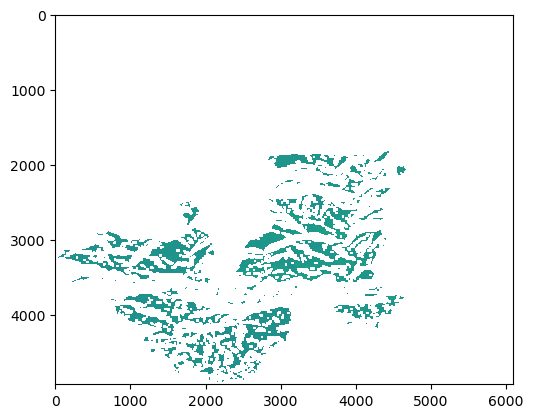

In [67]:
# plt.imshow(log_ratio, cmap='plasma')
plt.imshow(log_ratio)

## Classification
Selecting the K-Means model with n_clusters=4

4 labels corresponds to: **{1: 'Unburned', 2: 'Low', 3: 'Moderate', 4: 'High'}**

In [68]:
# model = KMeans(n_clusters=4, ##3
#                n_init=10,
#                random_state=1)

In [69]:
# classes = get_model_labels(log_ratio, model)
# classes = classes + 1

In [70]:
classes

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

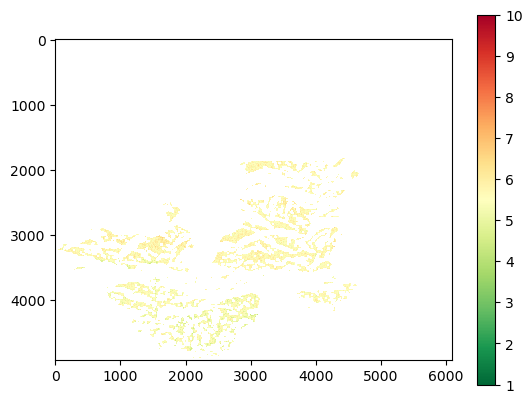

In [71]:
log_ratio_clean = log_ratio.copy()
log_ratio_clean[np.isinf(log_ratio_clean)] = np.nan  # Convert infinities to NaN
log_ratio_clean[log_ratio_clean == -np.inf] = np.nan

# Reshape ignoring NaN values
masked_data = log_ratio_clean[~np.isnan(log_ratio_clean)].reshape(-1, 1)


model = KMeans(n_clusters=10, n_init=10, random_state=1)
model.fit(masked_data)

# original shape
classes = np.full(log_ratio_clean.shape, np.nan)
classes[~np.isnan(log_ratio_clean)] = model.labels_ + 1  

plt.imshow(classes, cmap='RdYlGn_r')
plt.colorbar()

In [72]:
classes

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

---
This is what the output burn severity mapping will look like

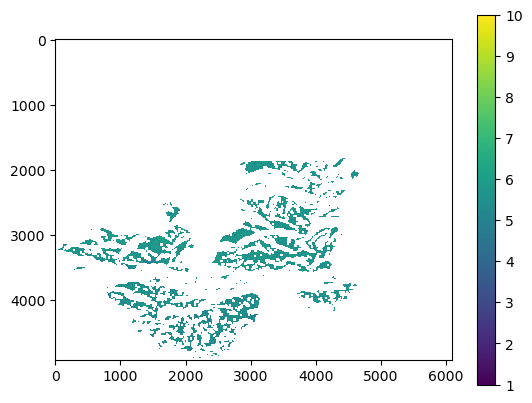

In [73]:
plt.imshow(classes)
plt.colorbar()

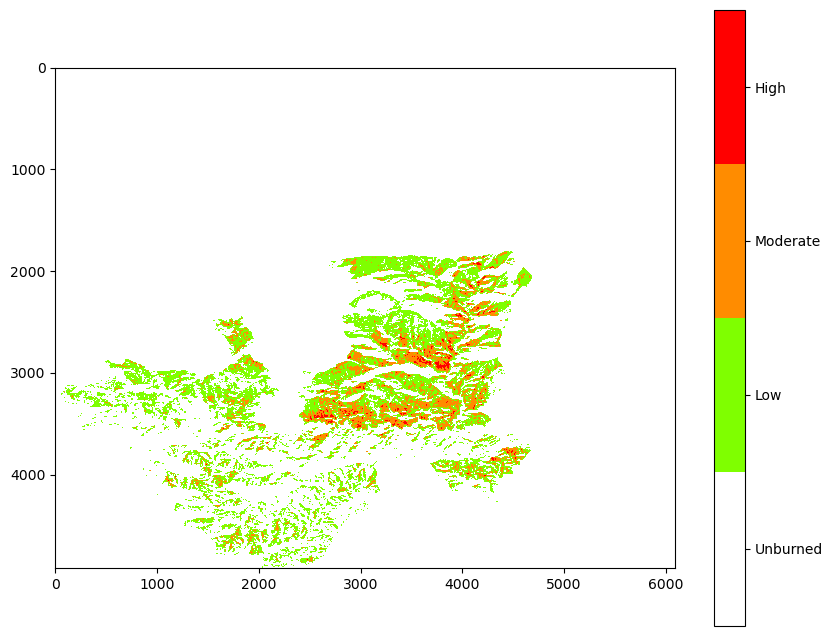

In [74]:
# Calculate log ratio (not kmeans clustering)
epsilon = 1e-10
hv_0_safe = np.maximum(hv_0, epsilon)
hv_1_safe = np.maximum(hv_1, epsilon)
log_ratio = np.log10(hv_0_safe/hv_1_safe)

# Create classification array
classes = np.zeros_like(log_ratio)

# Classify according to BAER dNBR thresholds
classes[(log_ratio > -0.1) & (log_ratio <= 0.1)] = 1    # Unburned
classes[(log_ratio > 0.1) & (log_ratio <= 0.27)] = 2    # Low Severity
classes[(log_ratio > 0.27) & (log_ratio <= 0.66)] = 3   # Moderate Severity
classes[log_ratio > 0.66] = 4                           # High Severity

# color map for dNBR
colors = [
            'none',      # Dark green for unburned
            '#7fff00',   # Light green for low
            '#FF8C00',   # Orange for moderate
            '#FF0000'    # Red for high
         ]   

custom_cmap = ListedColormap(colors)

# Visualize
plt.figure(figsize=(10, 8))
plt.imshow(classes, cmap=custom_cmap)
plt.clim(0.5, 4.5)  # Center the colors on the values
# plt.title('HV index difference normalized to nDBR scale (181011-201015)')

        
# colorbar labels
plt.colorbar(ticks=[1, 2, 3, 4]).set_ticklabels(['Unburned', 'Low', 'Moderate', 'High'])

In [86]:
print("hv_0 min/max:", np.nanmin(hv_0), np.nanmax(hv_0))
print("Number of valid pixels in mask:", np.sum(mask_image))

hv_0 min/max: -0.99999976 1.458546
Number of valid pixels in mask: 0


**Parameter**
- `output_name`(str): Name of the output burn seveity map [**.tif**]

In [81]:
# output_name = "fishla_sbs_10.tif"
output_name = "181011_HVHV_rtc_shp_bndy.jpg"

In [82]:
plt.savefig(output_name, format='jpg', dpi=300)

<Figure size 640x480 with 0 Axes>

In [83]:
with rasterio.open(output_name, "w", **profile_0) as dest:
    dest.write(classes, 1)

---
### Output Severity Distribution Visualization
Visualizes the distribution of the log ratio values for each burn severity class through boxplot

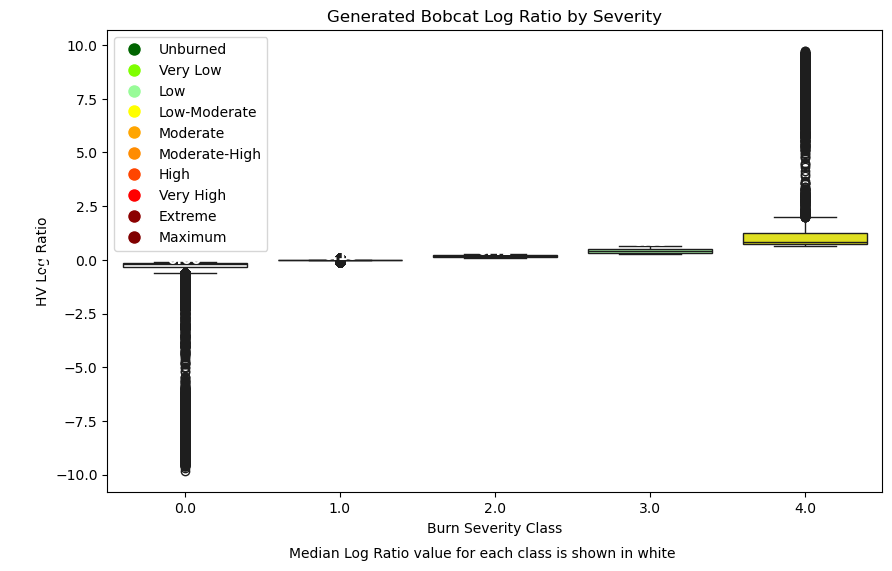

In [84]:
# Flatten and filter out np.nan values
flat_log_ratio = log_ratio[~np.isnan(classes)]
flat_classes = classes[~np.isnan(classes)]

# Create a DataFrame for seaborn
data = pd.DataFrame({'Classes': flat_classes, 'Log_Ratio': flat_log_ratio})

# Color Palette corresponding to MTBS's mapping
color_palette = {
    1: '#006400',  # Dark green (unburned)
    2: '#7fff00',  # Light green (very low severity)
    3: '#98FB98',  # Pale green
    4: '#FFFF00',  # Yellow
    5: '#FFA500',  # Orange
    6: '#FF8C00',  # Dark orange
    7: '#FF4500',  # Orange red
    8: '#FF0000',  # Red
    9: '#8B0000',  # Dark red
    10: '#800000'  # Maroon (highest severity)
}

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Classes', y='Log_Ratio', hue='Classes', data=data, palette=color_palette)

# Add median values
medians = data.groupby('Classes')['Log_Ratio'].median()
for idx, val in medians.items():
    plt.text(idx - 1, val, f'{val:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=10, color='white', fontweight='extra bold')

# Create a legend
legend_labels = {
    1: 'Unburned', 
    2: 'Very Low', 
    3: 'Low', 
    4: 'Low-Moderate',
    5: 'Moderate',
    6: 'Moderate-High',
    7: 'High',
    8: 'Very High',
    9: 'Extreme',
    10: 'Maximum'
}
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[key], markersize=10, markerfacecolor=color_palette[key]) for key in color_palette]
plt.legend(handles=legend_elements)

# Plot Labelings
plt.title('Generated Bobcat Log Ratio by Severity')
plt.xlabel('Burn Severity Class')
plt.ylabel('HV Log Ratio')
caption = 'Median Log Ratio value for each class is shown in white'
plt.figtext(0.5, 0, caption, ha='center', fontsize=10, color='black')
plt.show()